# Probabilistic Machine Learning with PyMC3: Part II
----

## Case studies

First, let's set up our working environment including required libraries.

In [2]:
# %load modeling.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'
import numpy as np
import pandas as pd
import qgrid                   # for beautiful tables
qgrid.set_defaults(show_toolbar = True)
import theano
import theano.tensor as tt
import pymc3 as pm
import dask.dataframe as dd
import pickle
import seaborn as sns             # for static plots
import matplotlib.pyplot as plt
from bqplot import *              # for interactive plots
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as ipw
fig_layout = ipw.Layout(width = "100%", height = "600px")
sns.set_context('notebook', font_scale = 1.1)
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 15, 'font.size': 20,
      'lines.linewidth': 4.0, 'lines.markersize': 40, 'font.family': "serif", 'font.serif': "cm",
      'savefig.dpi': 200, 'text.usetex': False, 'legend.fontsize': 20.0, 'axes.titlesize': 20, 
      "figure.figsize": [20, 12]}
sns.set(rc = rc)
sns.set_style("whitegrid") # or ticks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Clustering

### Step 1: Prepare the data

In [3]:
# create some data as a Numpy array or pandas df
# True parameter values
def create_dummy_data(K, N):
    pi = np.array([0.35, 0.4, 0.25])
    means = np.array([0, 5, 10])
    sigmas = np.array([0.5, 0.5, 1.0])

    components = np.random.randint(0, K, N) # also called latent z
    Y = np.random.normal(loc = means[components], scale = sigmas[components])
    return components, Y

K = 3; N = 100
components, Y_train = create_dummy_data(K, N)

In [4]:
# PyMC3 uses theano.shared variables so as
# to be able to exchange the data the model runs on
Y_shared = theano.shared(Y_train)

In [5]:
Y_shared.get_value().shape

(100,)

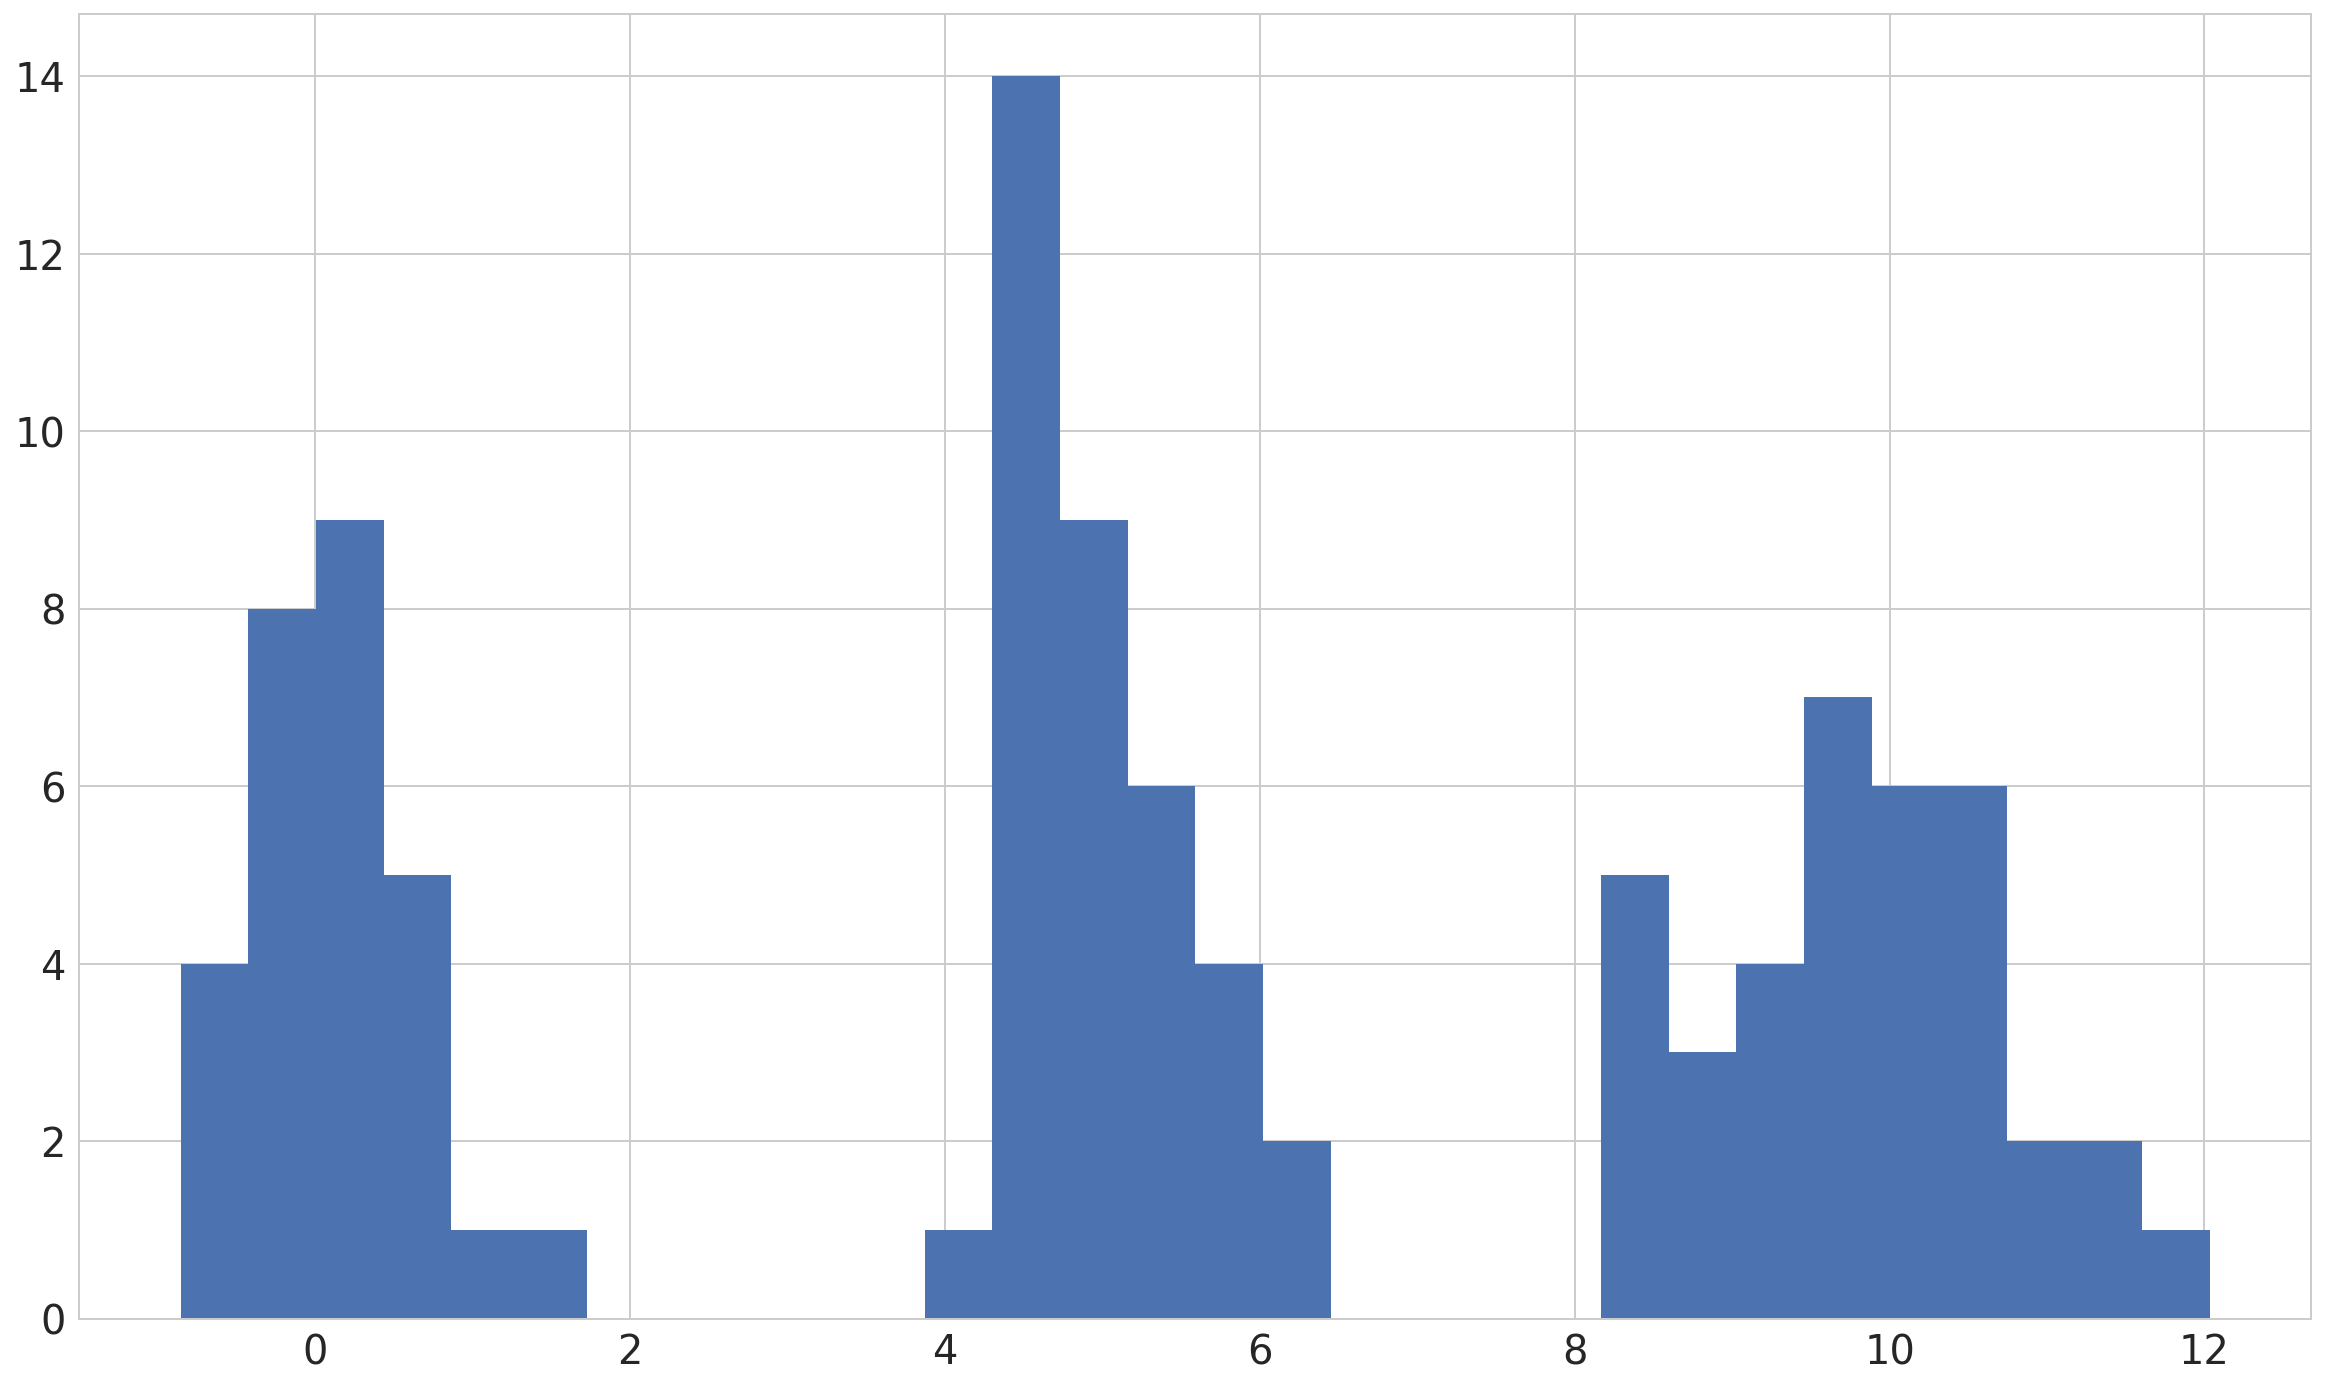

In [6]:
plt.hist(Y_shared.get_value(), bins = 30);

In [7]:
qgrid.show_grid(pd.DataFrame({"components" : components,
                              "Y_shared": Y_shared.get_value()
                              })
               )

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Step 2: Build the model

A natural parameterization of the Gaussian mixture model is as the latent variable model

\begin{split}\begin{align*}
\mu_1, \ldots, \mu_K
    & \sim N(0, \sigma^2) \\
\tau_1, \ldots, \tau_K
    & \sim \textrm{Gamma}(a, b) \\
\boldsymbol{\pi}
    & \sim \textrm{Dir}(\boldsymbol{\alpha}) \\
z\ |\ \boldsymbol{\pi}
    & \sim \textrm{Cat}(\boldsymbol{\pi}) \\
x\ |\ z
    & \sim N(\mu_z, \tau^{-1}_z).
\end{align*}\end{split}

A drawback of the above model parameterization is that the posterior relies on sampling the discrete latent variable  z. This reliance can cause slow mixing and ineffective exploration of the tails of the distribution. An alternative, equivalent parameterization that addresses these problems is to marginalize over z. The marginalized model is

\begin{split}\begin{align*}
\mu_1, \ldots, \mu_K
    & \sim N(0, \sigma^2) \\
\tau_1, \ldots, \tau_K
    & \sim \textrm{Gamma}(a, b) \\
\boldsymbol{\pi}
    & \sim \textrm{Dir}(\boldsymbol{\alpha}) \\
f(y\ |\ \boldsymbol{\pi})
    & = \sum_{i = 1}^K w_i\ N(y\ |\ \mu_i, \tau^{-1}_z),
\end{align*}\end{split}

Marginalizing z out of the model generally leads to faster mixing and better exploration of the tails of the posterior distribution. Marginalization over discrete parameters is a common trick in the Stan community, since Stan does not support sampling from discrete distributions. For further details on marginalization and several worked examples, see the *Stan User’s Guide and Reference Manual*.

PyMC3 supports marginalized Gaussian mixture models through its `NormalMixture class`. (It also supports marginalized general mixture models through its `Mixture` class.) Below we specify and fit a marginalized Gaussian mixture model to this data in PyMC3.

In [13]:
# instantiate a model using the pymc3 Model class
with pm.Model() as gmm_marginalized:
    
    # specify priors on unknown model parameters
    pi = pm.Dirichlet("pi", a = np.ones(K)/K, shape = K)
    means = pm.Normal("means", mu = [0, 0, 0], sd = 15, shape = K) # The center of each cluster
    std = pm.Gamma("std", alpha = 0.5, beta = 1, shape = K)
    
    # specify the likelihood of observations
    # data can be passed in as ndarray or pandas df
    obs = pm.NormalMixture("obs", w = pi, mu = means, sd = std, observed = Y_shared)

### Step 3: Perform inference

In [14]:
# sample from the posterior
with gmm_marginalized:     
    
    # obtain starting values via MAP or NUTs or ADVI or Metropolis
    start = pm.sample(draws = 1000, step = pm.Metropolis())
    
    # draw 5000 samples, run 4 chains in parallel in 4 cores (total 10,000 samples)
    # increase step size from default 0.8 to 0.999
    step = pm.NUTS(target_accept = 0.999, adapt_step_size = 0.001, max_treedepth = 15) 
    posterior_marginalized = pm.sample(draws = 1000, n_init = 1000, tune = 1000, 
                                       cores = 4, chains = 4, start = start, step = step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [std_log__]
>Metropolis: [means]
>Metropolis: [pi_stickbreaking__]
100%|██████████| 1500/1500 [00:01<00:00, 769.97it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std_log__, means, pi_stickbreaking__]
100%|██████████| 2000/2000 [00:26<00:00, 75.37it/s]


### Step 4: Diagnose convergence of the MCMC chains

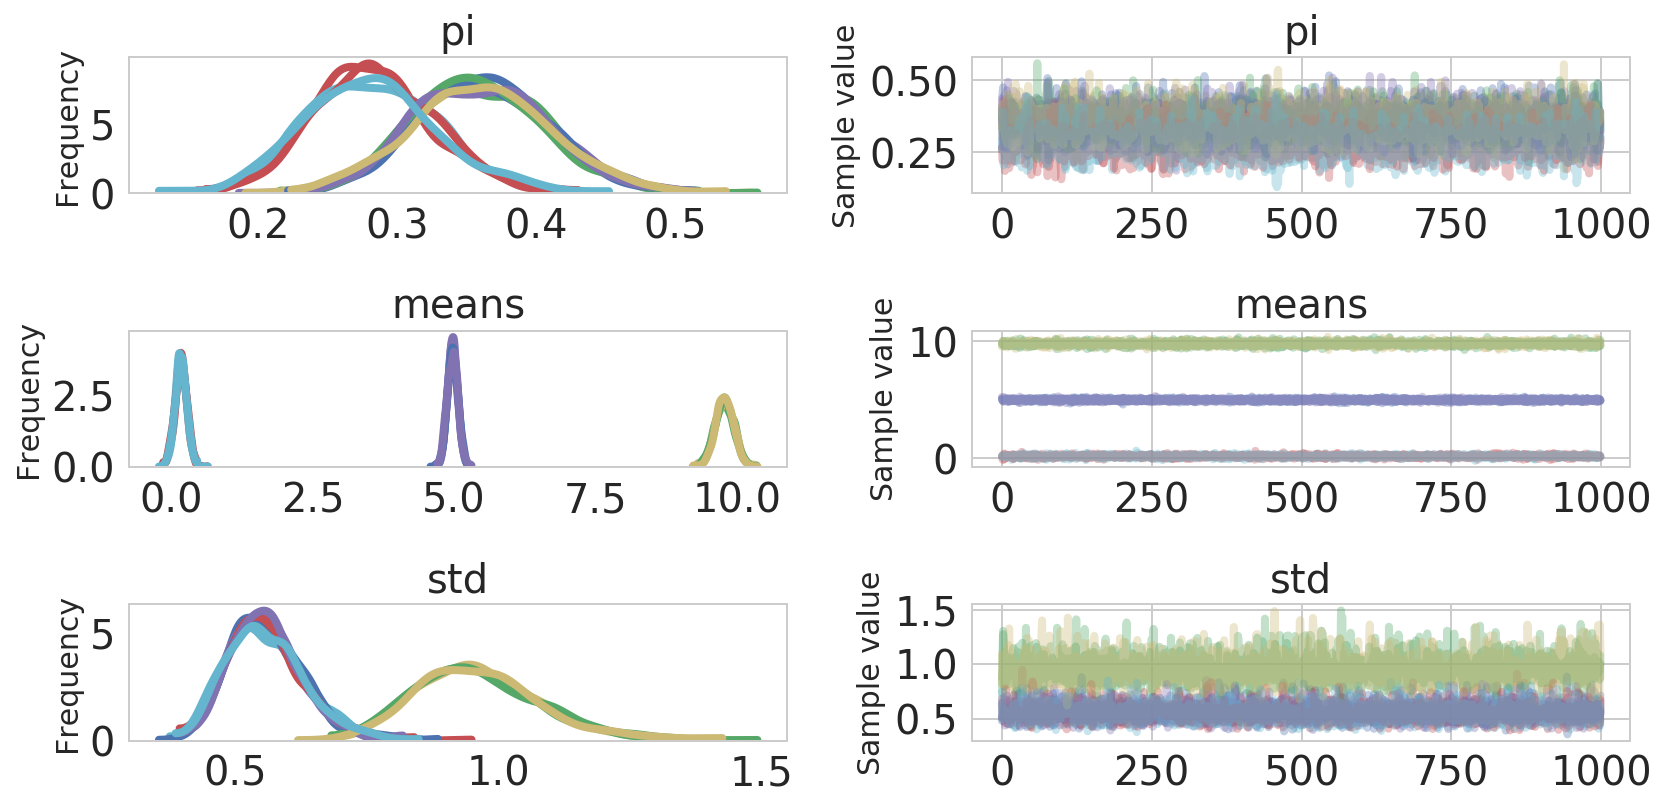

In [15]:
# a traceplot is the most common plot used to analyze sampling results
pm.traceplot(posterior_marginalized, varnames = ["pi", "means", "std"]);

One way to monitor whether a chain has converged to the equilibrium distribution is to compare its behavior to other randomly initialized chains. This is the motivation for the Gelman and Rubin (1992) potential scale reduction statistic, R̂ . The R̂ statistic measures the ratio of the average variance of samples within each chain to the variance of the pooled samples across chains; if all chains are at equilibrium, these will be the same and R̂ will be one. If the chains have not converged to a common distribution, the R̂ statistic will be greater than one. (Stan Development Team, 2016).

In [16]:
# also look at the Gelman-Rubin statistic
pm.gelman_rubin(posterior_marginalized, varnames = ["pi", "means", "std"])

{'means': array([0.99970754, 0.99971185, 0.99960943]),
 'pi': array([0.99986106, 0.99994822, 1.00102353]),
 'std': array([1.00001976, 0.99962482, 0.99951608])}

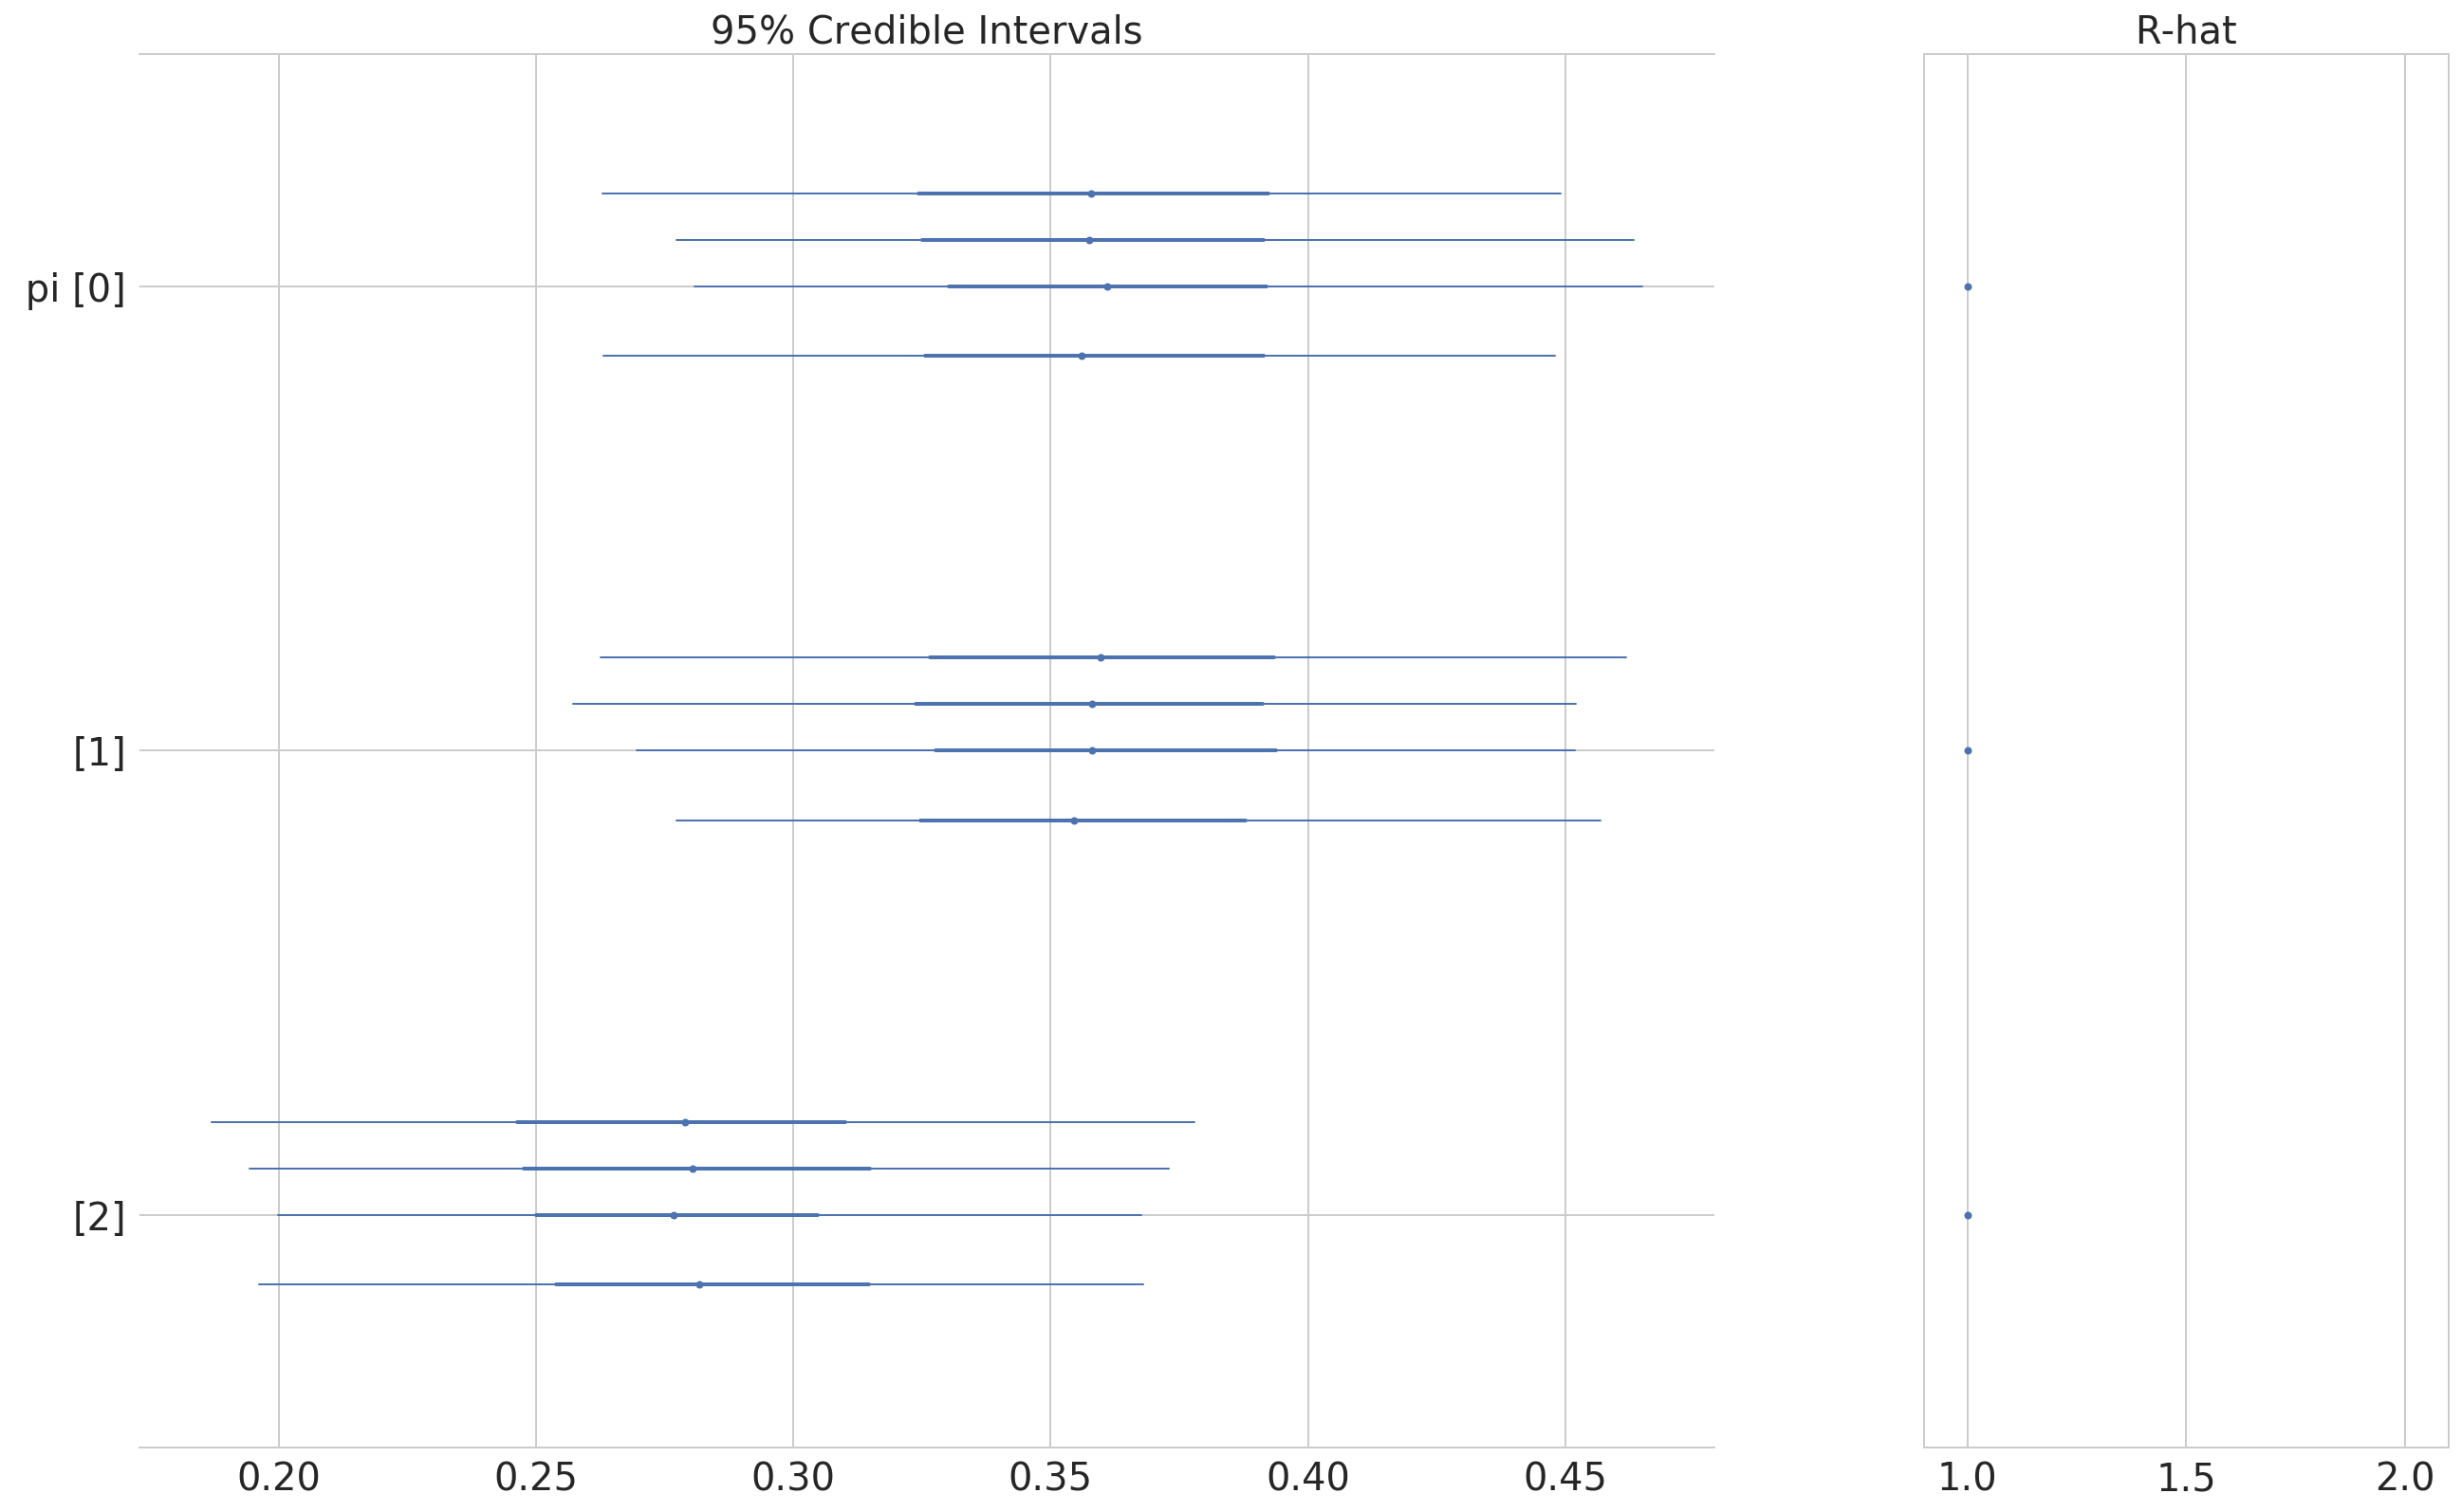

In [17]:
# also look at the forestplot for Rhat values
pm.forestplot(posterior_marginalized, varnames = ["pi"]);

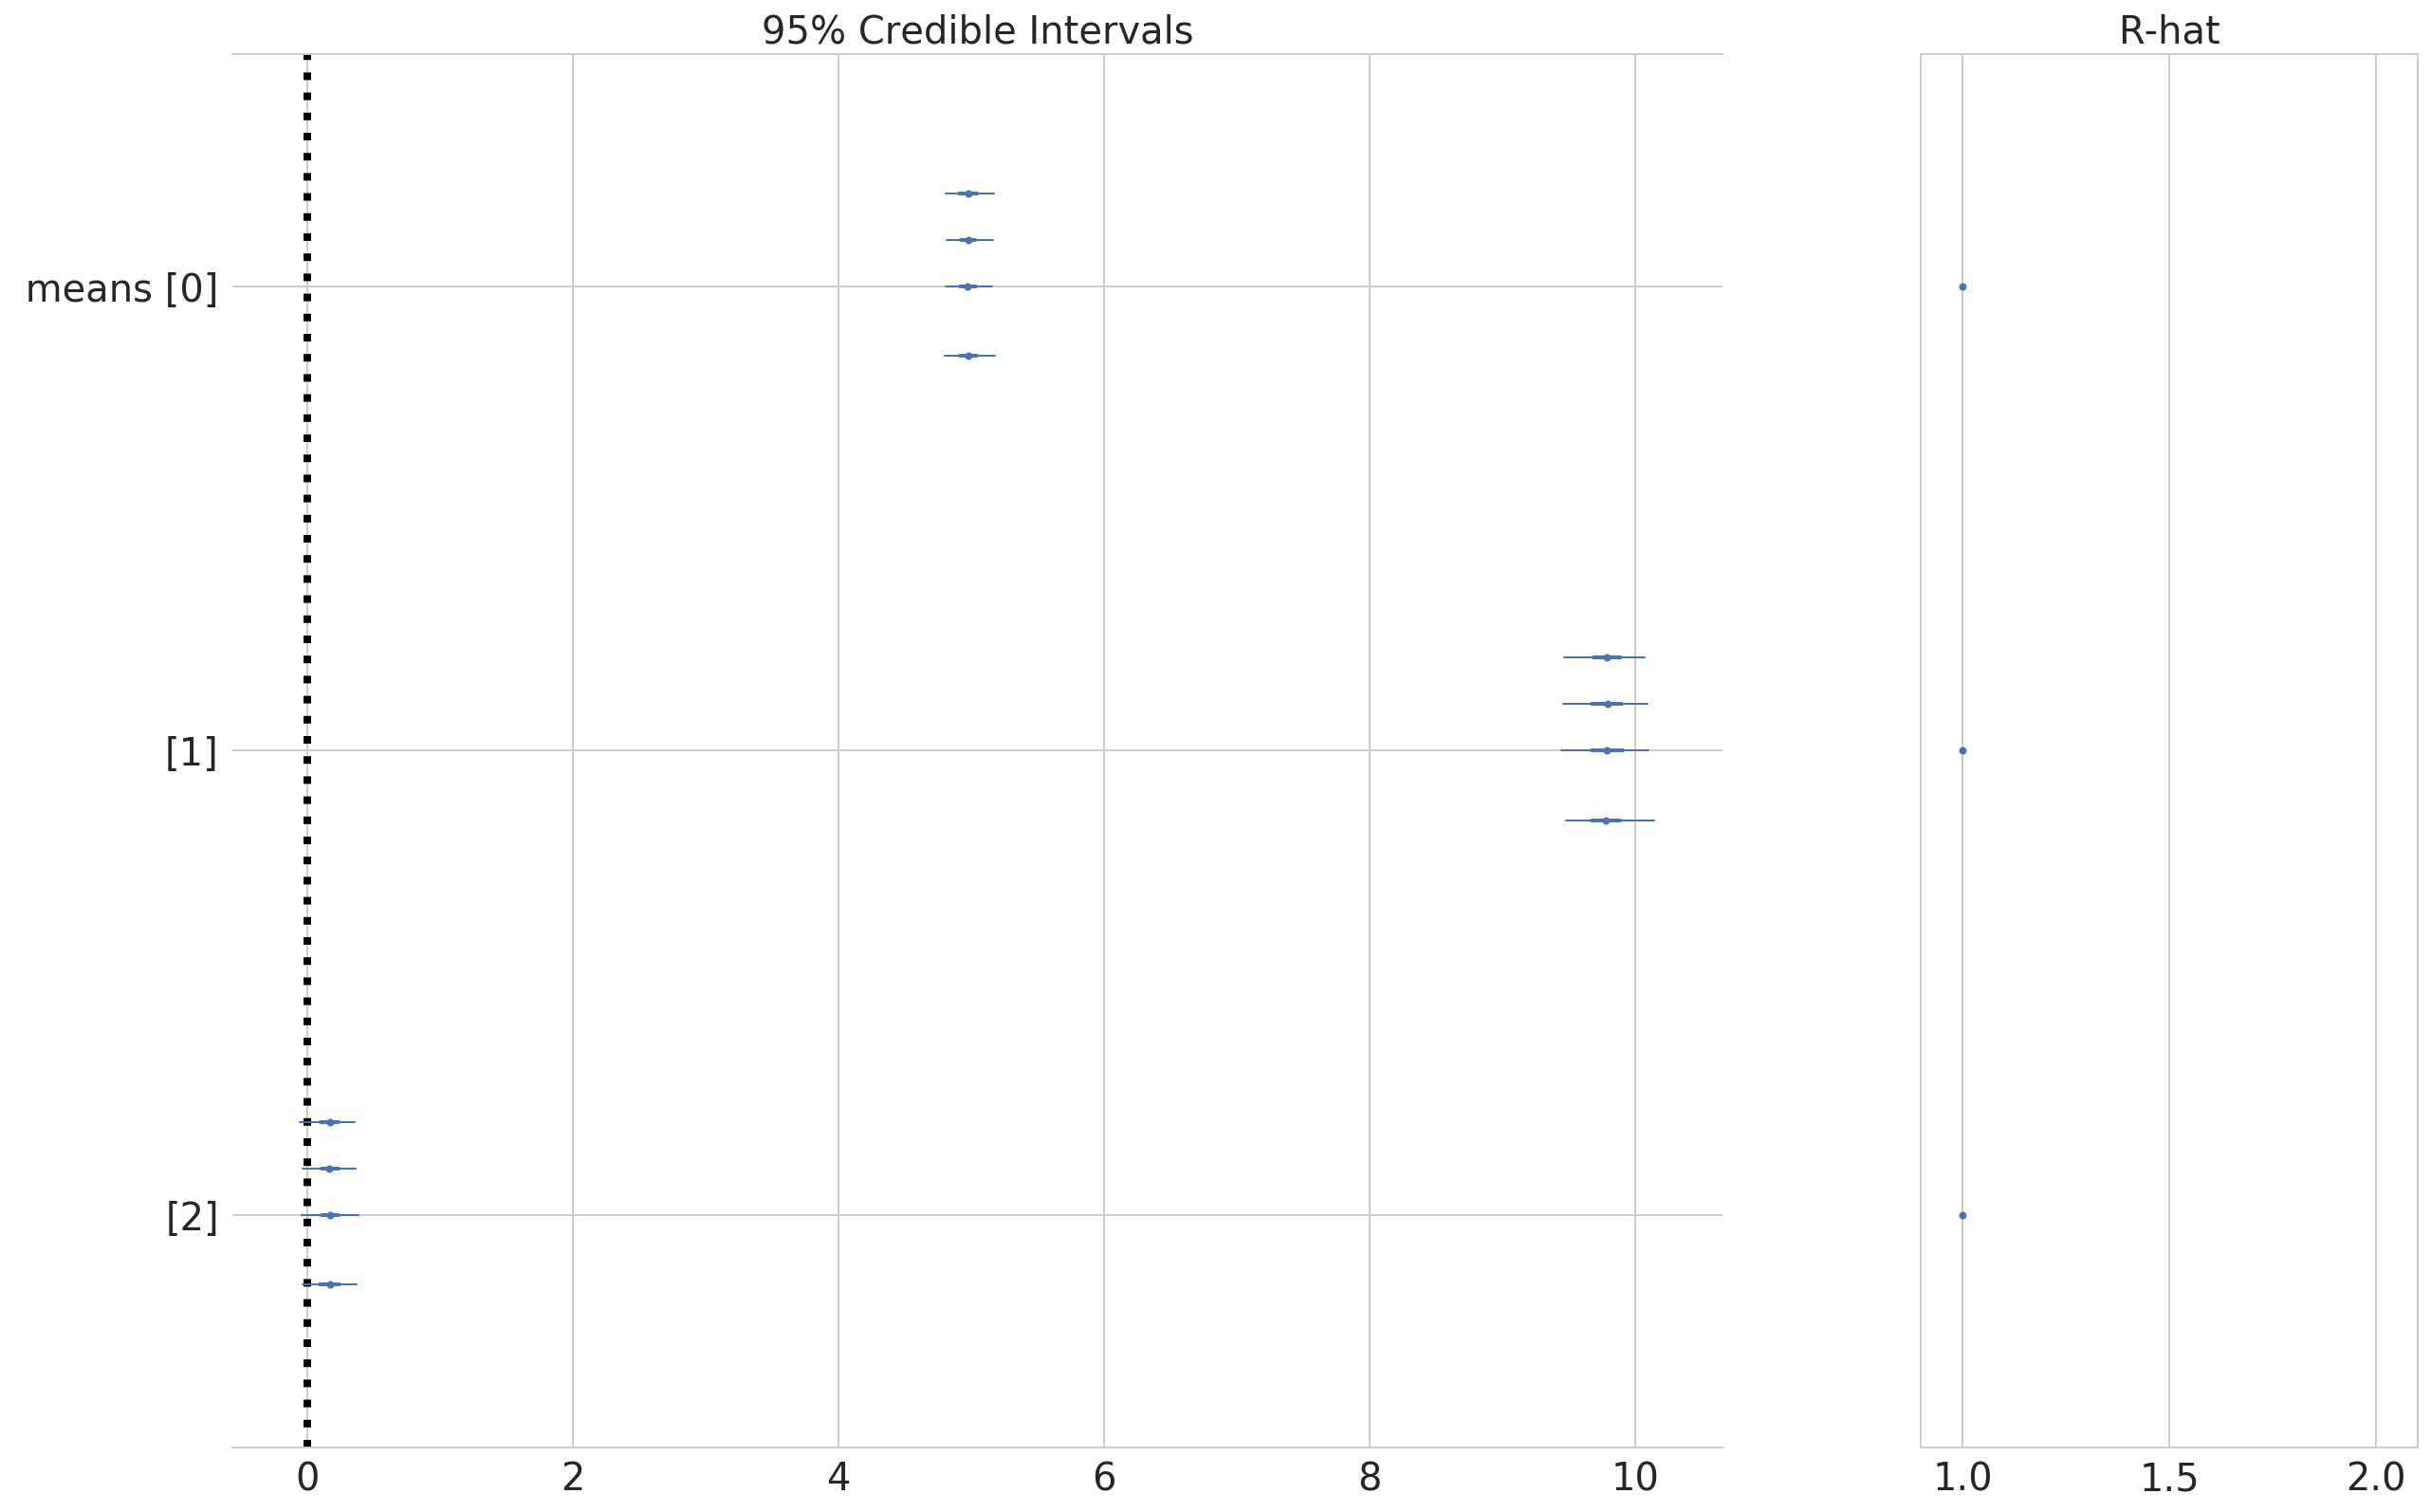

In [18]:
pm.forestplot(posterior_marginalized, varnames = ["means"]);

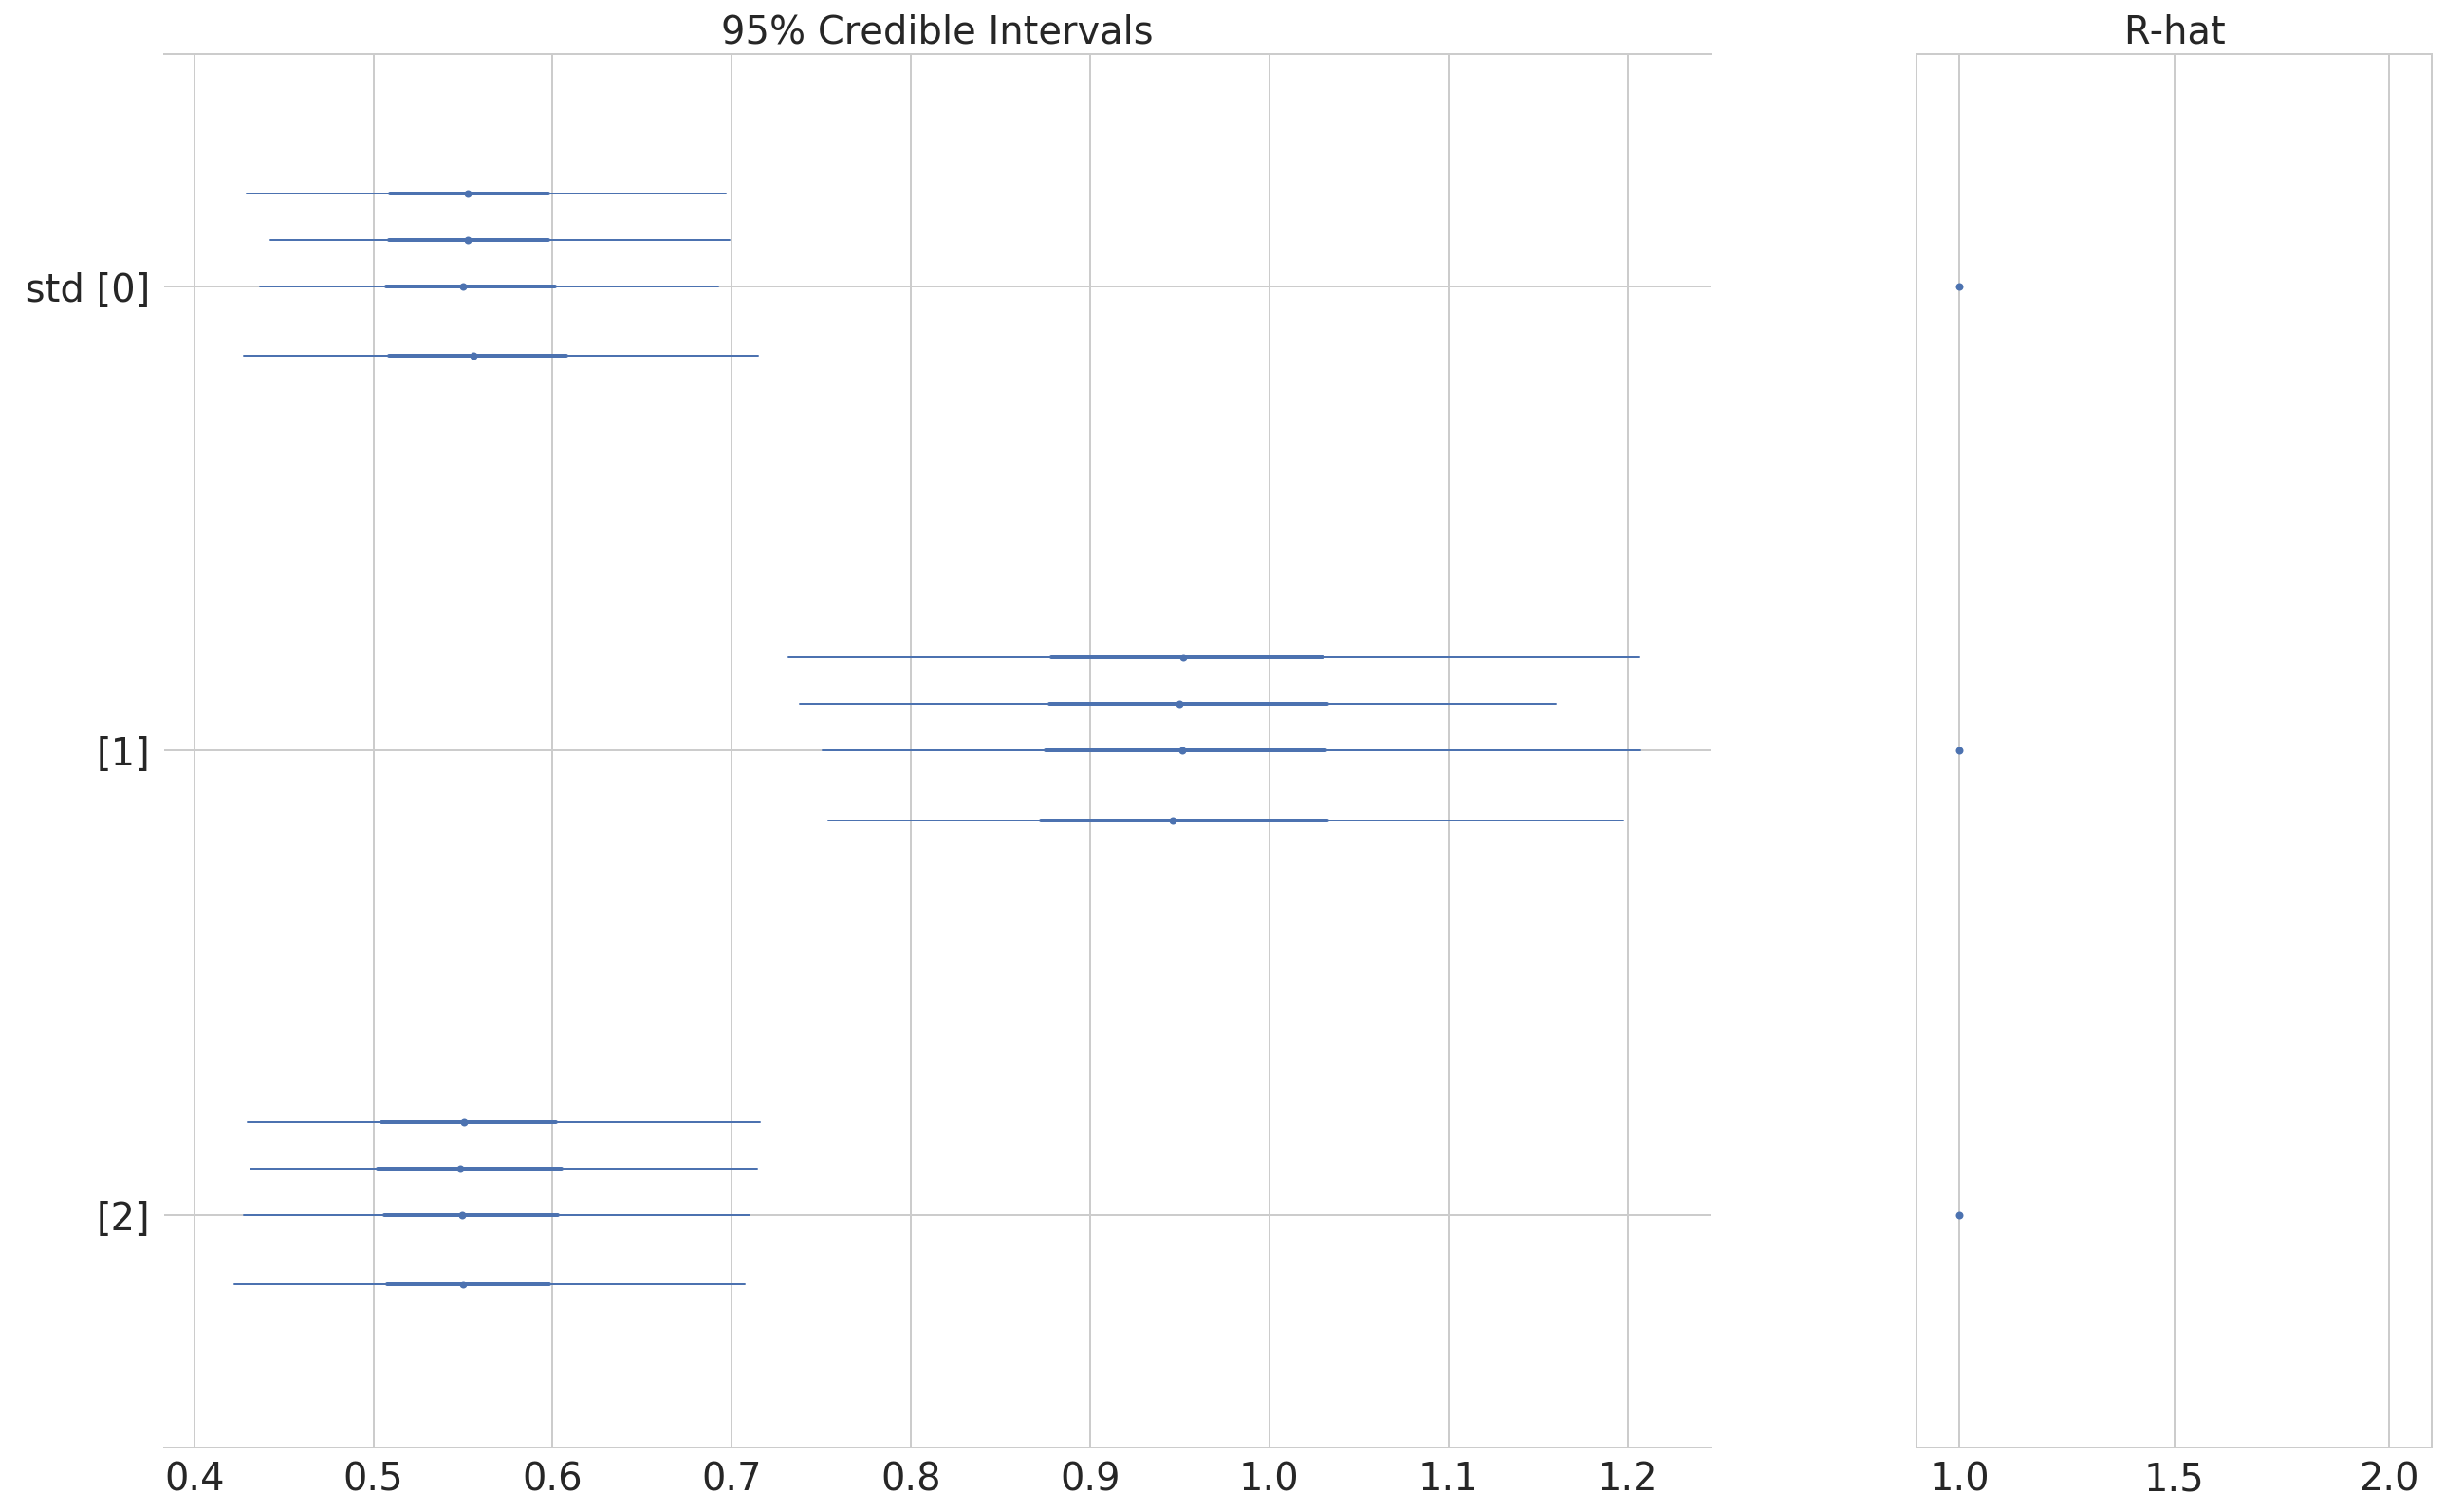

In [19]:
pm.forestplot(posterior_marginalized, varnames = ["std"]);

### Step 5: Critize the model

In [21]:
pm.summary(posterior_marginalized, varnames = ["pi", "means", "std"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
pi__0,0.359844,0.047538,0.000570,0.261524,0.447988,5756.062978,0.999861
pi__1,0.358922,0.048835,0.000700,0.269007,0.459631,5565.970478,0.999948
pi__2,0.281234,0.045534,0.000661,0.197209,0.376250,5059.218347,1.001024
means__0,4.976316,0.092676,0.001256,4.803890,5.167340,4967.555150,0.999708
means__1,9.783302,0.165409,0.002405,9.448147,10.090237,5106.181686,0.999712
means__2,0.170850,0.104132,0.001492,-0.039149,0.372119,4816.389053,0.999609
std__0,0.558513,0.069621,0.000886,0.431250,0.699041,4966.353264,1.000020
std__1,0.960196,0.118756,0.002015,0.754202,1.206862,4257.461089,0.999625
std__2,0.557694,0.074904,0.001120,0.425451,0.710297,4306.644375,0.999516


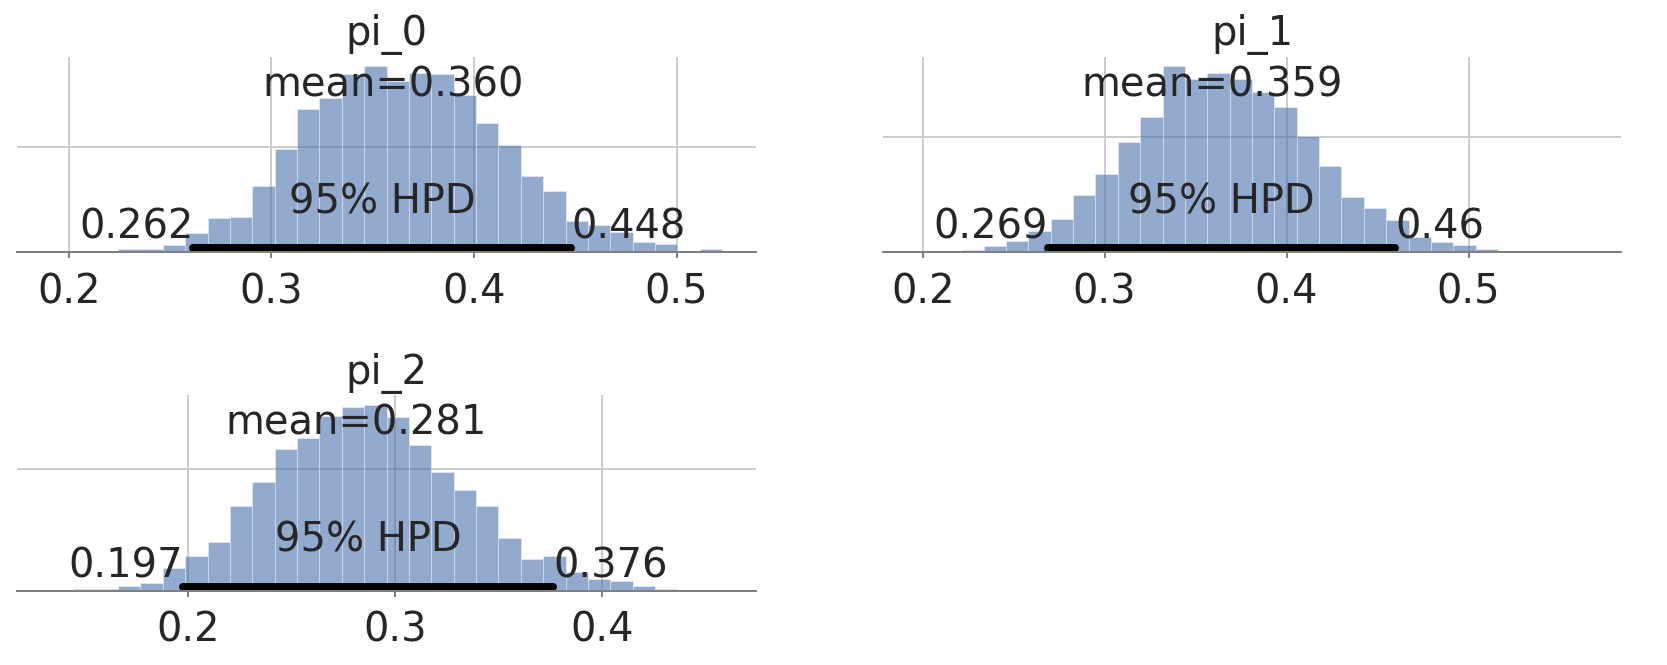

In [22]:
pm.plot_posterior(posterior_marginalized, varnames = ["pi"], alpha = 0.6);

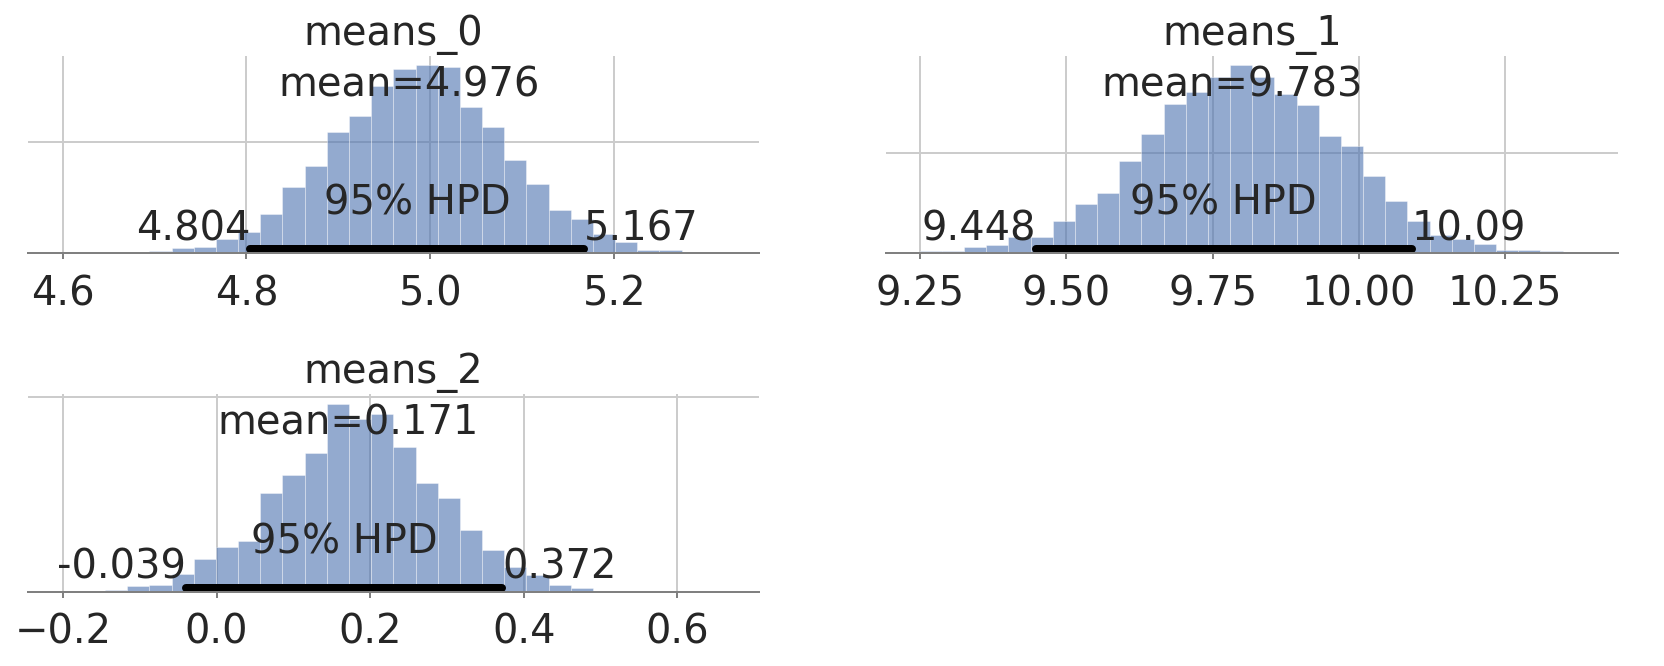

In [23]:
pm.plot_posterior(posterior_marginalized, varnames = ["means"], alpha = 0.6);

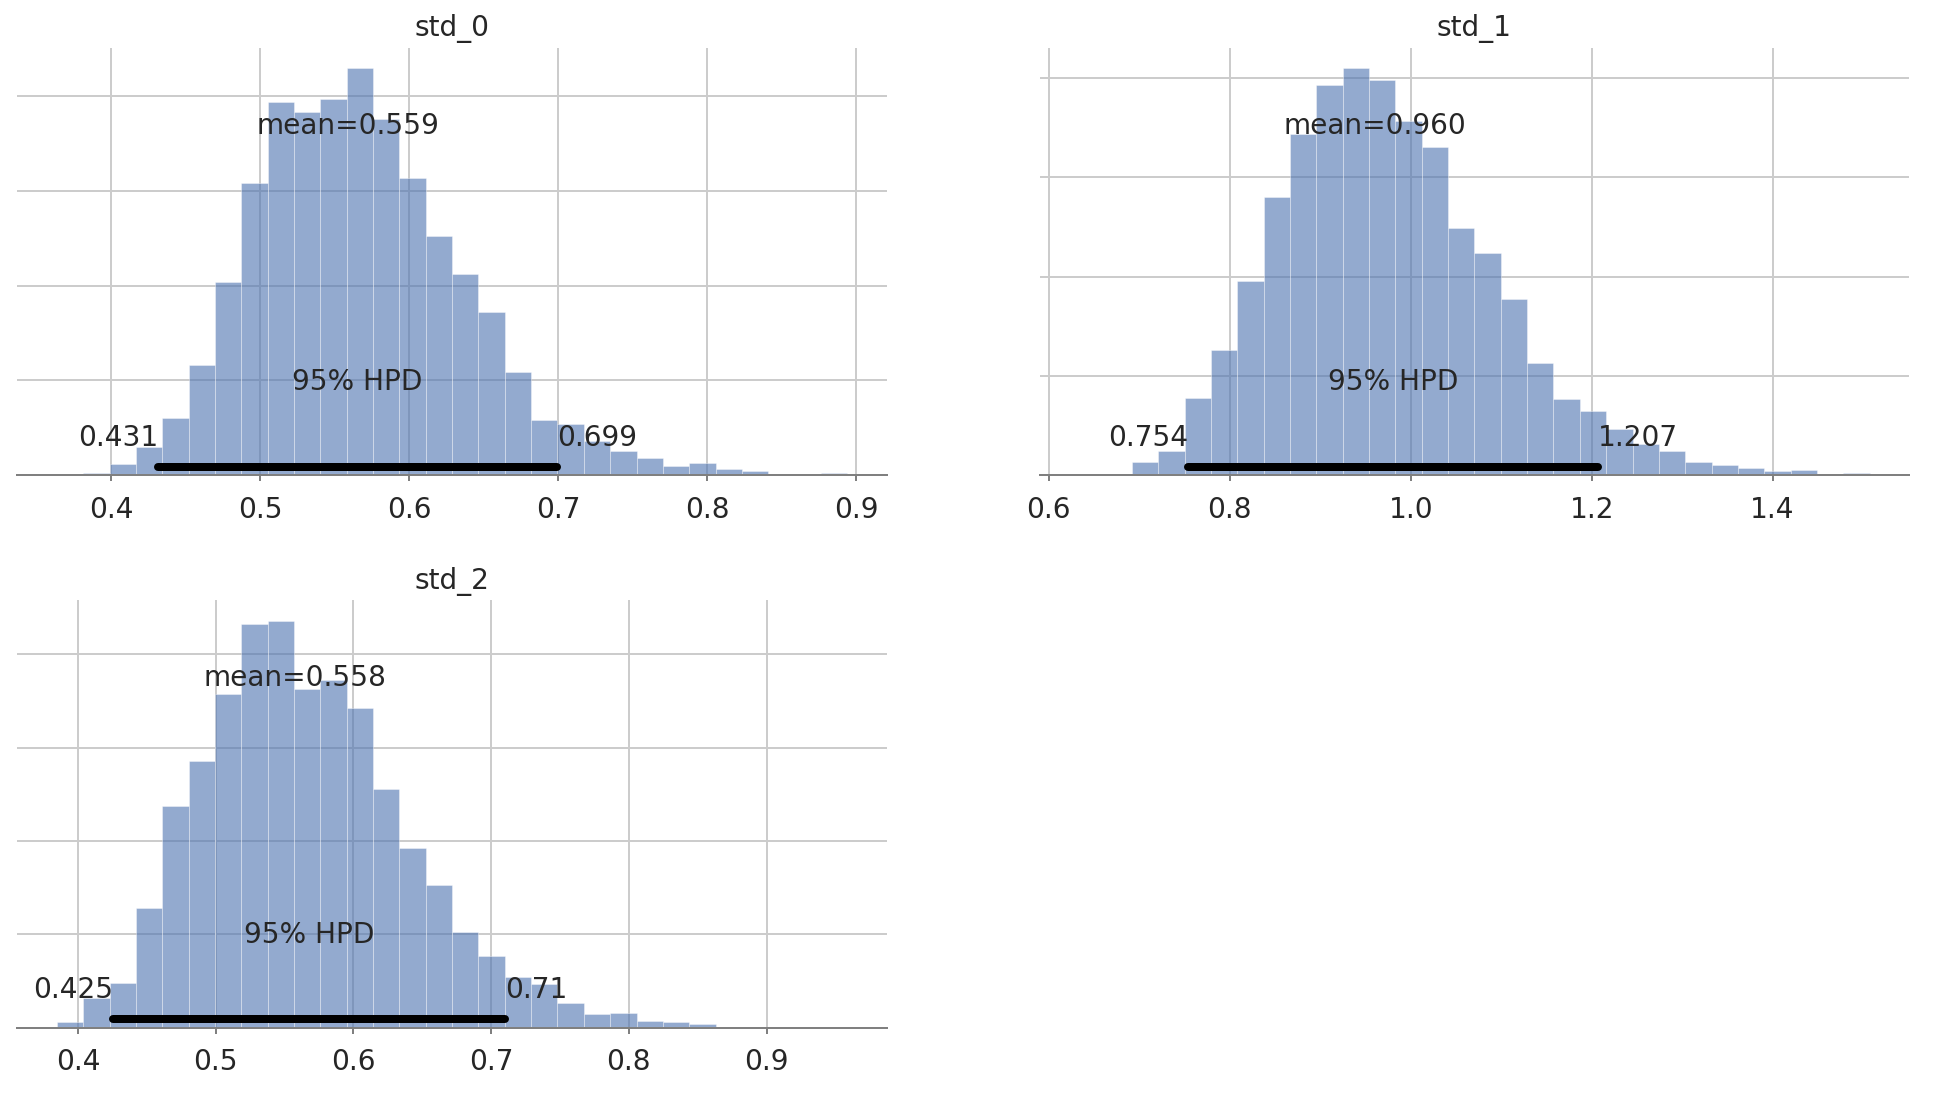

In [24]:
pm.plot_posterior(posterior_marginalized, varnames = ["std"], figsize = [14, 8], alpha = 0.6);

In [25]:
# Posterior predictive checks (PPCs) are a great way to validate the model
# i.e to check how data generated from the model deviates from the true distribution
# PPC involves generating data from the model using estimated parameters from the posterior
# use pm.sample_ppc to do posterior predictive checks
with gmm_marginalized:
    post_pred_gmm = pm.sample_ppc(posterior_marginalized, samples = 1000)

100%|██████████| 1000/1000 [00:01<00:00, 928.89it/s]


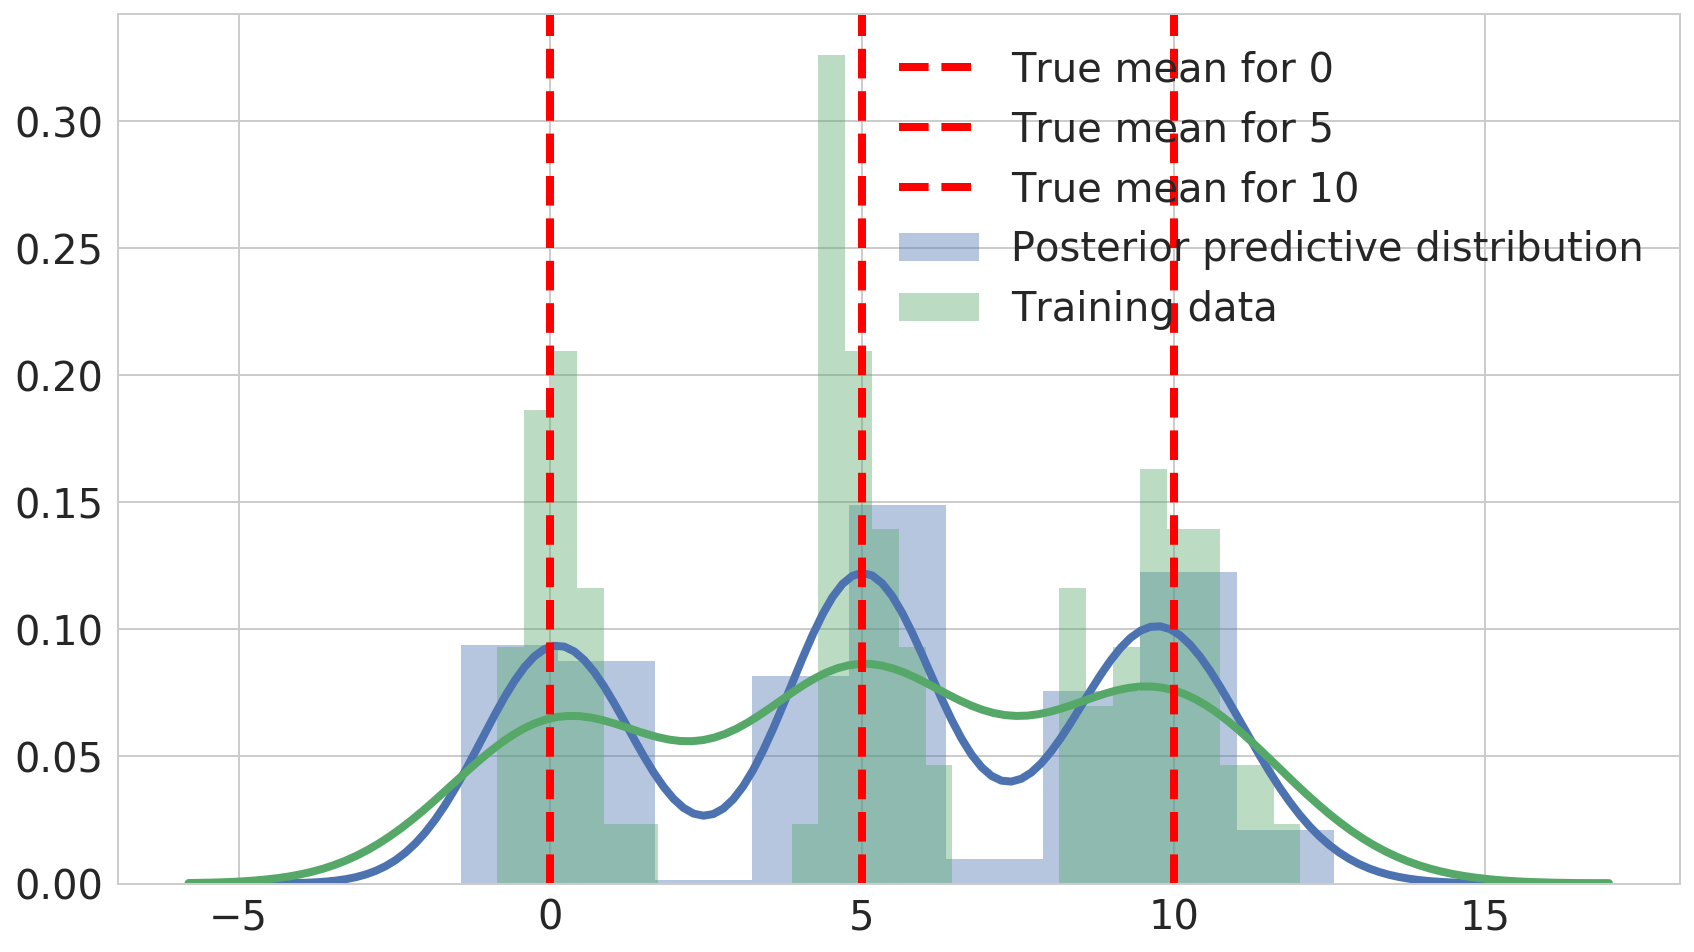

In [26]:
plt.figure(figsize = [14, 8])
ax = sns.distplot(post_pred_gmm['obs'], label='Posterior predictive distribution')
# ax = sns.distplot(posterior["simulated_obs"].mean(axis=1), label='Simulate data')
ax = sns.distplot(Y_shared.get_value(), bins = 30, label='Training data')
for true_mean in [0, 5, 10]:
    ax.axvline(true_mean, color='r', ls='--', 
               label='True mean for {cluster}'.format(cluster = true_mean)) 
ax.legend();

### Step 6: Use the model for prediction

In [27]:
# use pm.sample_ppc to do prediction on hold-out or unseen data  
# for hold-out or unseen data, pymc3 uses theano.shared variables so as
# to be able to exchange the data the model runs on

K = 3
N = 50
pi = np.array([0.35, 0.4, 0.25])
means = np.array([0, 5, 10])
sigmas = np.array([0.5, 0.5, 1.0])

components = np.random.randint(0, K, N) # also called latent z
new_obs = np.random.normal(loc = means[components], scale = sigmas[components])

# Changing values here will also change values in the model
Y_shared.set_value(new_obs)

# Simply running PPC will use the updated values and do prediction
with gmm_marginalized:
    post_pred_marginalized = pm.sample_ppc(posterior_marginalized, samples = 10000)    

100%|██████████| 10000/10000 [00:06<00:00, 1467.38it/s]


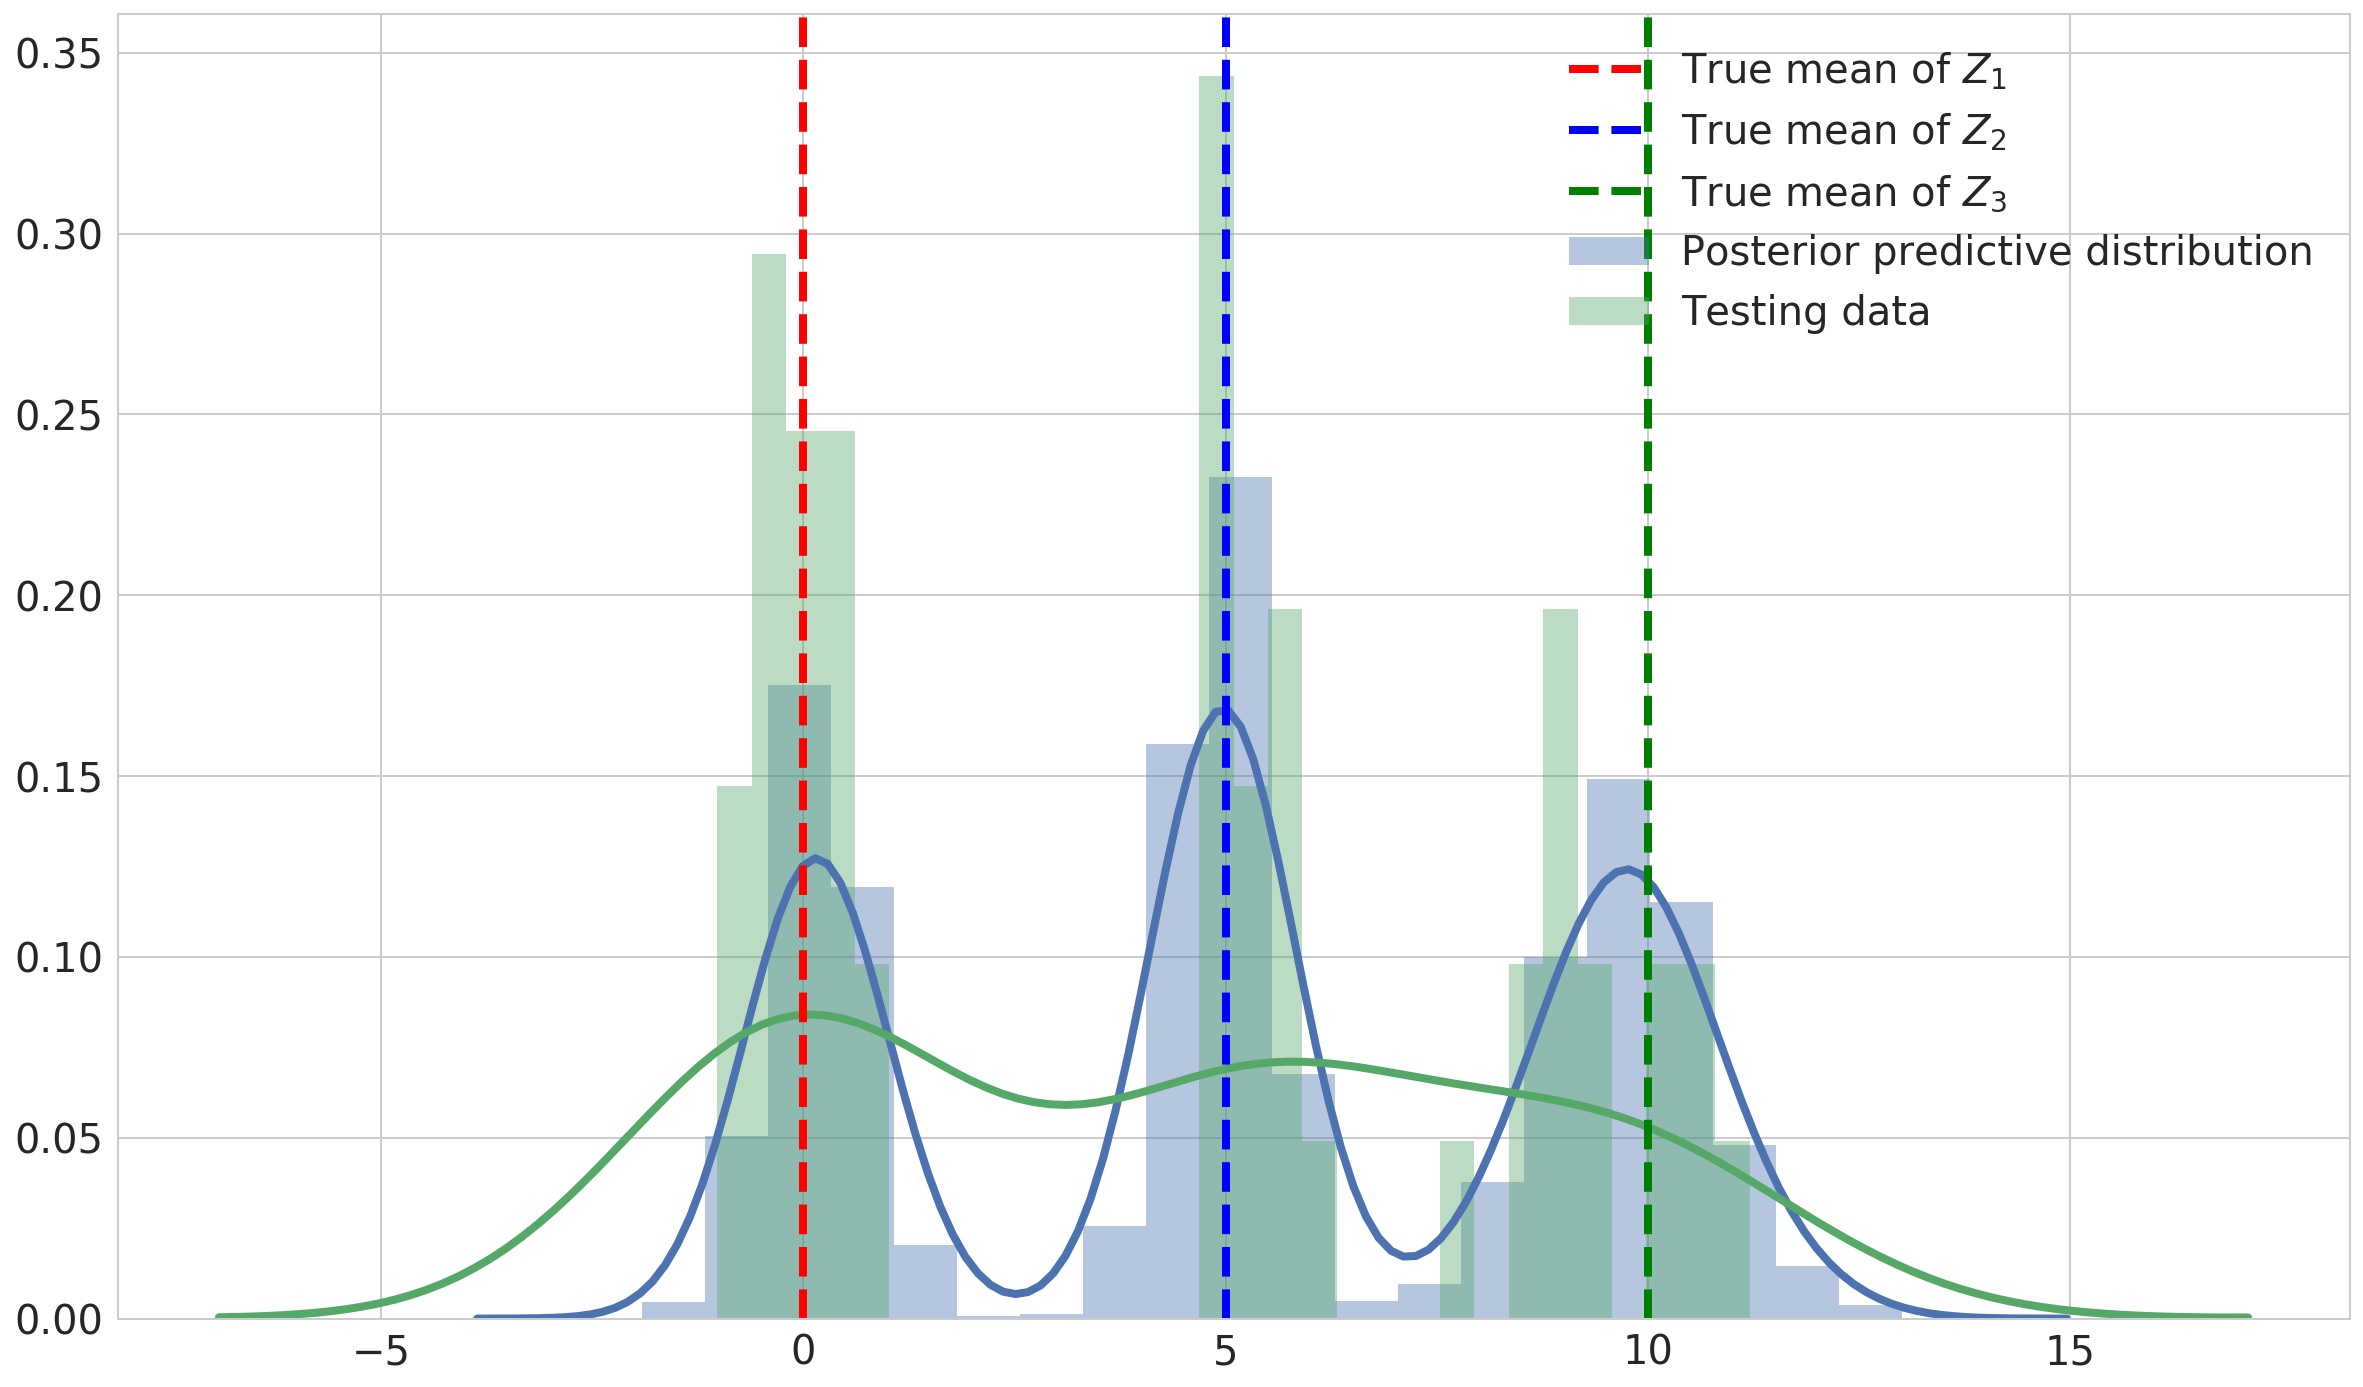

In [28]:
fig, ax = plt.subplots()
ax = sns.distplot(post_pred_marginalized['obs'], label = 'Posterior predictive distribution')
ax = sns.distplot(Y_shared.get_value(), bins = 30, label='Testing data')
ax.axvline(means[0], color='r', ls='--', label='True mean of $Z_1$')
ax.axvline(means[1], color='b', ls='--', label='True mean of $Z_2$')
ax.axvline(means[2], color='g', ls='--', label='True mean of $Z_3$')
ax.legend();

In [ ]:
# save the posterior to the file 'posterior_lm.pkl' for later use
with open('posterior_marginalized.pkl', 'wb') as f:
    pickle.dump(posterior_marginalized, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# load it at some future point
with open('posterior_marginalized.pkl', 'rb') as f:
    posterior_marginalized = pickle.load(f)

## How to debug a model

### Typical steps

* I run the code until before sampling, the model complied without a problem.

* Try to sample using the default option:

In [ ]:
with model:
    trace = pm.sample()

and confirm the same error. (tips: run with njobs=1 or cores=1 if you are on master, as the error is much cleaner)

* run with

In [ ]:
with model:
    trace = pm.sample(cores=1, init='adapt_diag')

and it can sample, indeed as explained above, the jitter is causing the problem in this case (we are trying to find a proper solution for it.)

* However, you got lots of warning:

In [ ]:
# The chain contains only diverging samples. The model is probably misspecified.
# The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
# The estimated number of effective samples is smaller than 200 for some parameters.

That’s quite likely because we have too few data and too many parameters. Also mixture model is difficult to sample 
* see also some of the related post on this discourse: Gaussian Mixture of regression 3, Mixture with multiple observations 2.

* Try to optimized the model by setting K=2, got a ValueError: Bad initial energy: inf. The model might be misspecified.

* debug following Get nan or inf from model.logp (model.test point) is an attestation of incorrectly configured model?

In [ ]:
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

alpha -1.8378770664093453
beta -1.8378770664093453
gamma -6.443047252397437
delta -6.443047252397437
tau_log__ -2.0
obs -inf

found -inf logp of the node obs

* double check the input to obs and its logp:

In [ ]:
# use .tag.test_value to check the current default
w.tag.test_value
mu.tag.test_value
tau.tag.test_value

the problem is that w is not summed to 1, a normalization within the model should do the trick.

In [ ]:
w_ = stick_breaking(v)
w = pm.Deterministic('w', w_/w_.sum(axis=1, keepdims=True))

### Profiling
Sometimes computing the likelihood is not as fast as we would like. Theano provides handy profiling tools, which pymc3 provides a wrapper `model.profile` which returns a `ProfileStats` object. Here we’ll profile the likelihood and gradient for the stochastic volatility example.

Then call profile and summarize it.

In [ ]:
model.profile(model.logpt).summary()

In [ ]:
model.profile(gradient(model.logpt, model.vars)).summary()

## Dependencies

In [29]:
# Dependencies
%load_ext watermark
%watermark -dmvgp numpy,scipy,pandas,matplotlib,seaborn,patsy,pymc3,theano,joblib

2018-04-26 

CPython 3.6.3
IPython 6.2.1

numpy 1.14.1
scipy 1.0.0
pandas 0.22.0
matplotlib 2.1.2
seaborn 0.7.1
patsy 0.4.1
pymc3 3.4.1
theano 1.0.1
joblib 0.11

compiler   : GCC 7.2.0
system     : Linux
release    : 4.9.87-linuxkit-aufs
machine    : x86_64
processor  : x86_64
CPU cores  : 6
interpreter: 64bit
Git hash   : 86801176693ca0e7a72b8265d7d1383b9d772e63
